In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import io
import os
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [3]:
pangenie_svs_sample = read_vcf("pangenie_merged_bi_nosnvs_26sample.vcf")
pangenie_svs_sample[['INFO_ID']] = pangenie_svs_sample['INFO'].str.split(';', expand=True)[2]
pangenie_svs_sample['INFO_ID'] = pangenie_svs_sample['INFO_ID'].str.lstrip('ID=')
pangenie_svs_sample[['type']] = pangenie_svs_sample['INFO_ID'].str.split('-', expand=True)[2]

In [4]:
pangenie_svs_sample.shape

(1129810, 37)

In [5]:
col_list = pangenie_svs_sample['type'].values.tolist()
pd.Series(col_list).value_counts()

DEL    672432
INS    457378
dtype: int64

In [6]:
pangenie_DEL_sample = pangenie_svs_sample[pangenie_svs_sample['INFO_ID'].str.contains('DEL')]
pangenie_INS_sample = pangenie_svs_sample[pangenie_svs_sample['INFO_ID'].str.contains('INS')]

### deletions

In [7]:
pangenie_DEL_sample_new = pangenie_DEL_sample[[
'CHROM', 'FILTER', 'INFO_ID', 'FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
##### removed NA12329

In [9]:
for col in pangenie_DEL_sample_new.iloc[:, 4:]:
    pangenie_DEL_sample_new[col] = pangenie_DEL_sample_new[col].str[:3]

In [11]:
for col in pangenie_DEL_sample_new.columns:
    pangenie_DEL_sample_new.loc[pangenie_DEL_sample_new[col].astype(str).str.startswith('0/0'), col] = '0'
    pangenie_DEL_sample_new.loc[pangenie_DEL_sample_new[col].astype(str).str.startswith('.:.'), col] = '0'
    pangenie_DEL_sample_new.loc[pangenie_DEL_sample_new[col].astype(str).str.startswith('0/1'), col] = '1'
    pangenie_DEL_sample_new.loc[pangenie_DEL_sample_new[col].astype(str).str.startswith('1/0'), col] = '1'
    pangenie_DEL_sample_new.loc[pangenie_DEL_sample_new[col].astype(str).str.startswith('1/1'), col] = '1'

In [13]:
pangenie_DEL_sample_new.iloc[:,4: ] = pangenie_DEL_sample_new.iloc[:,4: ].astype(str).astype(int)
pangenie_DEL_sample_new['Sum']=pangenie_DEL_sample_new.iloc[:,4: ].sum(axis=1)
pangenie_DEL_sample_new_atleast3 = pangenie_DEL_sample_new[pangenie_DEL_sample_new['Sum'].astype(int) >= 5]
pangenie_DEL_sample_new_atleast3['START_POS'] = pangenie_DEL_sample_new_atleast3['INFO_ID'].str.split('-', expand=True)[1]
pangenie_DEL_sample_new_atleast3['TYPE'] = pangenie_DEL_sample_new_atleast3['INFO_ID'].str.split('-', expand=True)[2]
pangenie_DEL_sample_new_atleast3['LEN'] = pangenie_DEL_sample_new_atleast3['INFO_ID'].str.split('-', expand=True)[3]
pangenie_DEL_sample_new_atleast3.iloc[:,[31,33]] = pangenie_DEL_sample_new_atleast3.iloc[:,[31,33]].astype(str).astype(int)
# VCF files in fact are providing a single 1-based position for a variant, end = start + len -1
pangenie_DEL_sample_new_atleast3['END_POS'] = pangenie_DEL_sample_new_atleast3['START_POS'] + pangenie_DEL_sample_new_atleast3['LEN']-1
pangenie_DEL_sample_new_atleast3_new = pangenie_DEL_sample_new_atleast3[[
'CHROM', 'START_POS','END_POS', 'TYPE','LEN', 'FILTER', 'INFO_ID', 'FORMAT', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732', 'Sum'
    ]]

In [14]:
pangenie_DEL_sample_new_atleast3_50 = pangenie_DEL_sample_new_atleast3_new[pangenie_DEL_sample_new_atleast3_new['LEN'] >= 50]
pangenie_DEL_sample_new_atleast3_50.shape

(13876, 35)

In [15]:
pangenie_DEL_sample_new_atleast3_50_zero = pangenie_DEL_sample_new_atleast3_50[pangenie_DEL_sample_new_atleast3_50.iloc[:, 8:].eq(0).any(1)]
pangenie_DEL_sample_new_atleast3_50_start_end = pangenie_DEL_sample_new_atleast3_50_zero[['CHROM', 'START_POS', 'END_POS', 'INFO_ID']]
pangenie_DEL_sample_new_atleast3_50_start_end.shape

(12670, 4)

### insertions

In [16]:
pangenie_INS_sample_new = pangenie_INS_sample[[
'CHROM', 'FILTER', 'INFO_ID', 'FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
##### removed NA12329

In [18]:
for col in pangenie_INS_sample_new.iloc[:, 4:]:
    pangenie_INS_sample_new[col] = pangenie_INS_sample_new[col].str[:3]

In [20]:
for col in pangenie_INS_sample_new.columns:
    pangenie_INS_sample_new.loc[pangenie_INS_sample_new[col].astype(str).str.startswith('0/0'), col] = '0'
    pangenie_INS_sample_new.loc[pangenie_INS_sample_new[col].astype(str).str.startswith('.:.'), col] = '0'
    pangenie_INS_sample_new.loc[pangenie_INS_sample_new[col].astype(str).str.startswith('0/1'), col] = '1'
    pangenie_INS_sample_new.loc[pangenie_INS_sample_new[col].astype(str).str.startswith('1/0'), col] = '1'
    pangenie_INS_sample_new.loc[pangenie_INS_sample_new[col].astype(str).str.startswith('1/1'), col] = '1'

In [22]:
pangenie_INS_sample_new.iloc[:,4: ] = pangenie_INS_sample_new.iloc[:,4: ].astype(str).astype(int)
pangenie_INS_sample_new['Sum']=pangenie_INS_sample_new.iloc[:,4: ].sum(axis=1)
pangenie_INS_sample_new_atleast3 = pangenie_INS_sample_new[pangenie_INS_sample_new['Sum'].astype(int) >= 5]
pangenie_INS_sample_new_atleast3['START_POS'] = pangenie_INS_sample_new_atleast3['INFO_ID'].str.split('-', expand=True)[1]
pangenie_INS_sample_new_atleast3['TYPE'] = pangenie_INS_sample_new_atleast3['INFO_ID'].str.split('-', expand=True)[2]
pangenie_INS_sample_new_atleast3['LEN'] = pangenie_INS_sample_new_atleast3['INFO_ID'].str.split('-', expand=True)[3]
pangenie_INS_sample_new_atleast3.iloc[:,[31,33]] = pangenie_INS_sample_new_atleast3.iloc[:,[31,33]].astype(str).astype(int)
pangenie_INS_sample_new_atleast3['END_POS'] = pangenie_INS_sample_new_atleast3['START_POS']
pangenie_INS_sample_new_atleast3_new = pangenie_INS_sample_new_atleast3[[
'CHROM', 'START_POS','END_POS', 'TYPE','LEN', 'FILTER', 'INFO_ID', 'FORMAT', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732', 'Sum'
    ]]

In [23]:
pangenie_INS_sample_new_atleast3_50 = pangenie_INS_sample_new_atleast3_new[pangenie_INS_sample_new_atleast3_new['LEN'] >= 50]
pangenie_INS_sample_new_atleast3_50.shape

(19992, 35)

In [24]:
pangenie_INS_sample_new_atleast3_50_zero = pangenie_INS_sample_new_atleast3_50[pangenie_INS_sample_new_atleast3_50.iloc[:, 8:].eq(0).any(1)]
pangenie_INS_sample_new_atleast3_50_start_end = pangenie_INS_sample_new_atleast3_50_zero[['CHROM', 'START_POS', 'END_POS', 'INFO_ID']]
pangenie_INS_sample_new_atleast3_50_start_end.shape

(17279, 4)

## SVs' impact on boundary strength

In [25]:
all_DEL_merged = pd.read_csv('all_DEL_26merged_cutoff_flank_inter30_5kb_boundaries_100kb_only01_new10kb.bed', sep='\t', header=None)
all_DEL_merged.columns =['CHROM', 'START_POS', 'END_POS', 'INFO_ID', 'BOUND_CHR', 'FLANK_START', 'FLANK_END', 'BOUND_SCORE']

In [26]:
all_DEL_merged.shape

(12729, 8)

In [27]:
all_INS_merged = pd.read_csv('all_INS_26merged_cutoff_flank_inter30_5kb_boundaries_100kb_only01_new10kb.bed', sep='\t', header=None)
all_INS_merged.columns =['CHROM', 'START_POS', 'END_POS', 'INFO_ID', 'BOUND_CHR', 'FLANK_START', 'FLANK_END', 'BOUND_SCORE']

In [28]:
all_INS_merged.shape

(17331, 8)

In [29]:
all_DEL_boundary_1 = all_DEL_merged.loc[all_DEL_merged.iloc[:, 4] != '.']
all_DEL_boundary_2 = all_DEL_boundary_1.reset_index(drop=True)

In [30]:
all_DEL_boundary_2.shape

(1812, 8)

In [31]:
all_INS_boundary_1 = all_INS_merged.loc[all_INS_merged.iloc[:, 4] != '.']
all_INS_boundary_2 = all_INS_boundary_1.reset_index(drop=True)

In [32]:
all_INS_boundary_2.shape

(2596, 8)

In [33]:
sample_ids = ['GM18534','GM18939','GM19036','GM19240','GM19650','GM19833','GM20509','GM20847','HG00096','HG00171',
              'HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492',
              'HG02587','HG03009','HG03065','HG03371','HG03683','HG03732']
file_directory = '/home/Hi-C'
import glob
for i in sample_ids:
    file_pattern = os.path.join(file_directory, f"experiment_{i}/aligned/fanc_insulation_SCALE/BS_cutoff_inter30_10kb.boundaries_100kb_new10kb.bed")
    sample_file = glob.glob(file_pattern)
    sample_merged_BS = pd.read_csv(sample_file[0], sep='\t', header=None)
    sample_merged_BS =sample_merged_BS[[0, 1, 2, 3, 4, 5, 6, 8]]
    sample_merged_BS.columns =['BOUND_CHR', 'FLANK_START', 'FLANK_END', 'BOUND_SCORE','BOUND_CHR_samp', 'BOUND_START_samp', 'BOUND_END_samp', 'BOUND_SCORE_samp']
    sample_merged_BS_1 = sample_merged_BS.groupby(['BOUND_CHR', 'FLANK_START', 'FLANK_END'], as_index=False)['BOUND_SCORE_samp'].median()
    all_DEL_boundary_2[i] = all_DEL_boundary_2.merge(sample_merged_BS_1, how="left", left_on=["BOUND_CHR", "FLANK_START", "FLANK_END"], right_on=["BOUND_CHR", "FLANK_START", "FLANK_END"])['BOUND_SCORE_samp']
    all_INS_boundary_2[i] = all_INS_boundary_2.merge(sample_merged_BS_1, how="left", left_on=["BOUND_CHR", "FLANK_START", "FLANK_END"], right_on=["BOUND_CHR", "FLANK_START", "FLANK_END"])['BOUND_SCORE_samp']

#### Mann-Whitney U test for genotypes and boundary scores

In [36]:
all_DEL_boundary_2.shape

(1812, 34)

In [37]:
all_INS_boundary_2.shape

(2596, 34)

In [38]:
all_DEL_boundary_2['num_NaNs'] = all_DEL_boundary_2.iloc[:, 8:].isna().sum(1)
all_INS_boundary_2['num_NaNs'] = all_INS_boundary_2.iloc[:, 8:].isna().sum(1)

In [39]:
all_DEL_boundary_2['num_NaNs'].max()

26

In [40]:
all_INS_boundary_2['num_NaNs'].max()

26

In [41]:
all_DEL_boundary_2[all_DEL_boundary_2['num_NaNs'] == 26].index

Int64Index([  12,   19,   76,  274,  275,  321,  331,  332,  370,  371,  420,
             612,  615,  661,  662,  668,  669,  670,  755,  756,  818,  892,
             905,  906, 1045, 1110, 1196, 1358, 1360, 1362, 1364, 1369, 1370,
            1371, 1372, 1450, 1451, 1456, 1533, 1534, 1660, 1661, 1676, 1680,
            1726],
           dtype='int64')

In [42]:
all_INS_boundary_2[all_INS_boundary_2['num_NaNs'] == 26].index

Int64Index([ 128,  129,  386,  387,  417,  577,  642,  730,  933,  962,  963,
             965,  966,  967,  981,  982,  983,  984,  985, 1017, 1020, 1100,
            1123, 1170, 1171, 1172, 1312, 1333, 1338, 1339, 1343, 1541, 1542,
            1548, 1583, 1786, 1925, 1926, 1928, 1937, 1938, 1939, 1940, 1988,
            2082, 2086, 2171, 2183, 2184, 2518, 2555],
           dtype='int64')

In [43]:
all_DEL_boundary_2_noNA = all_DEL_boundary_2[all_DEL_boundary_2.num_NaNs < 26]
all_INS_boundary_2_noNA = all_INS_boundary_2[all_INS_boundary_2.num_NaNs < 26]

In [46]:
# Replace NaN Values with Zeros, because those NA boundary scores mean there is no boundary, so we can changed them to zero
all_DEL_boundary_3 = all_DEL_boundary_2_noNA.fillna(0).drop_duplicates()
all_INS_boundary_3 = all_INS_boundary_2_noNA.fillna(0).drop_duplicates()
all_DEL_boundary_3 = all_DEL_boundary_3.reset_index(drop=True)
all_INS_boundary_3 = all_INS_boundary_3.reset_index(drop=True)

In [47]:
all_DEL_boundary_3.shape

(1767, 35)

In [48]:
all_INS_boundary_3.shape

(2545, 35)

In [49]:
all_DEL_boundary_id = list(all_DEL_boundary_3['INFO_ID'])
DEL_list = list(set(all_DEL_boundary_id))
len(DEL_list)

1712

In [50]:
all_INS_boundary_id = list(all_INS_boundary_3['INFO_ID'])
INS_list = list(set(all_INS_boundary_id))
len(INS_list)

2495

In [52]:
DEL_genotype = pd.read_csv('pangenie_svs_26sample_ALL_DEL_atleast3_50_genotype_only01.bed', sep='\t', header=0)
INS_genotype = pd.read_csv('pangenie_svs_26sample_ALL_INS_atleast3_50_genotype_only01.bed', sep='\t', header=0)
DEL_genotype_1 = DEL_genotype.iloc[:, :-1]
INS_genotype_1 = INS_genotype.iloc[:, :-1]
DEL_boundary_genotype = DEL_genotype_1[DEL_genotype_1['INFO_ID'].isin(all_DEL_boundary_id)]
INS_boundary_genotype = INS_genotype_1[INS_genotype_1['INFO_ID'].isin(all_INS_boundary_id)]
DEL_boundary_genotype = DEL_boundary_genotype[[
'CHROM', 'START_POS', 'END_POS', 'TYPE', 'LEN', 'FILTER', 'INFO_ID','FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]
INS_boundary_genotype = INS_boundary_genotype[[
'CHROM', 'START_POS', 'END_POS', 'TYPE', 'LEN', 'FILTER', 'INFO_ID','FORMAT','NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [53]:
DEL_boundary_genotype_1 = DEL_boundary_genotype.reset_index(drop=True)
DEL_boundary_genotype_1.shape

(1712, 34)

In [54]:
INS_boundary_genotype_1 = INS_boundary_genotype.reset_index(drop=True)
INS_boundary_genotype_1.shape

(2495, 34)

In [57]:
### test for genotypes 0 and 1 (binary genotypes, only 0/0 and others)
pvalue= []

for i in range(0, len(all_DEL_boundary_3)):
    DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1.loc[:,'INFO_ID'] == all_DEL_boundary_3.loc[i,'INFO_ID']].iloc[:,8:]
    genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = all_DEL_boundary_3.iloc[i,8:34].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})
    
    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')
      
    try:
        U, p = mannwhitneyu(x=df_new[0].dropna().tolist(), y=df_new[1].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except ValueError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
all_DEL_boundary_3['pvalue_0_1'] = pvalue

In [58]:
### test for genotypes 0 and 1 (binary genotypes, only 0/0 and others)
pvalue= []

for i in range(0, len(all_INS_boundary_3)):
    INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1.loc[:,'INFO_ID'] == all_INS_boundary_3.loc[i,'INFO_ID']].iloc[:,8:]
    genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
    boundary_score_list = all_INS_boundary_3.iloc[i,8:34].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})
    
    df_new = df.assign(BS=df.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')
      
    try:
        U, p = mannwhitneyu(x=df_new[0].dropna().tolist(), y=df_new[1].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except ValueError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
all_INS_boundary_3['pvalue_0_1'] = pvalue

In [59]:
def fdr_correction(group):
    _, corrected_pvalues, _, _ = multipletests(group['pvalue_0_1'], method='fdr_bh')
    group['qvalue'] = corrected_pvalues
    return group

In [60]:
corrected_del = all_DEL_boundary_3.groupby('INFO_ID').apply(fdr_correction)
corrected_del.shape

(1767, 37)

In [61]:
corrected_ins = all_INS_boundary_3.groupby('INFO_ID').apply(fdr_correction)
corrected_ins.shape

(2545, 37)

In [62]:
all_DEL_boundary_3_sig = corrected_del[corrected_del['qvalue'] < 0.05]
all_DEL_boundary_3_sig.shape

(65, 37)

In [63]:
all_INS_boundary_3_sig = corrected_ins[corrected_ins['qvalue'] < 0.05]
all_INS_boundary_3_sig.shape

(120, 37)

In [64]:
len(all_DEL_boundary_3_sig['INFO_ID'].drop_duplicates())

64

In [65]:
len(all_INS_boundary_3_sig['INFO_ID'].drop_duplicates())

120

#### Visualization of chr8-644401-DEL-5014 and chr19-37789443-INS-1092

In [66]:
all_DEL_boundary_3_sig[all_DEL_boundary_3_sig['INFO_ID'] == 'chr8-644401-DEL-5014']

,CHROM,START_POS,END_POS,INFO_ID,BOUND_CHR,FLANK_START,FLANK_END,BOUND_SCORE,GM18534,GM18939,...,HG02492,HG02587,HG03009,HG03065,HG03371,HG03683,HG03732,num_NaNs,pvalue_0_1,qvalue
1625,chr8,644401,649414,chr8-644401-DEL-5014,chr8,640001,665000,0.2359586358070373,0.733518,0.0,...,0.0,1.323045,0.953547,1.064899,0.0,0.0,0.0,14,0.002524,0.002524
1626,chr8,644401,649414,chr8-644401-DEL-5014,chr8,645001,670000,0.2359586358070373,0.733518,0.0,...,0.0,1.323045,0.953547,1.064899,0.0,0.0,0.0,14,0.002524,0.002524


In [86]:
boundary_score_list = all_DEL_boundary_3_sig.loc[1625][8:34].values.tolist()
DEL_boundary_genotype_all = DEL_boundary_genotype_1[DEL_boundary_genotype_1.loc[:,'INFO_ID'] == all_DEL_boundary_3_sig.loc[1625]['INFO_ID']].iloc[:,8:]
genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
df_DEL = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_DEL_new = df_DEL.assign(BS=df_DEL.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

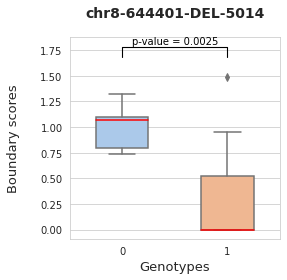

In [197]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_DEL_new[[0, 1]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr8-644401-DEL-5014', pad=20, fontsize=14, fontweight='bold')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_DEL_new[1].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0025", ha='center', va='bottom', color=col)

plt.show()

In [94]:
all_INS_boundary_3_sig[all_INS_boundary_3_sig['INFO_ID'] == 'chr19-37789443-INS-1092']

,CHROM,START_POS,END_POS,INFO_ID,BOUND_CHR,FLANK_START,FLANK_END,BOUND_SCORE,GM18534,GM18939,...,HG02492,HG02587,HG03009,HG03065,HG03371,HG03683,HG03732,num_NaNs,pvalue_0_1,qvalue
1194,chr19,37789443,37789443,chr19-37789443-INS-1092,chr19,37780001,37805000,0.2639830112457275,1.533405,0.289078,...,0.373349,0.765727,0.34978,0.0,0.340655,0.0,0.61169,6,0.001807,0.001807


In [95]:
boundary_score_list = all_INS_boundary_3_sig.loc[1194][8:34].values.tolist()
INS_boundary_genotype_all = INS_boundary_genotype_1[INS_boundary_genotype_1.loc[:,'INFO_ID'] == all_INS_boundary_3_sig.loc[1194]['INFO_ID']].iloc[:,8:]
genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
df_INS = pd.DataFrame({'genotypes' : genotypes_list,
                   'boundary_score' : boundary_score_list})    
df_INS_new = df_INS.assign(BS=df_INS.groupby('genotypes').cumcount()).pivot('BS','genotypes','boundary_score')

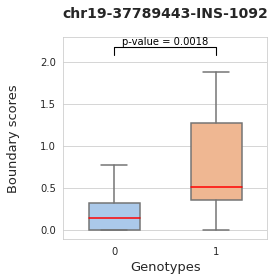

In [196]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_INS_new[[0, 1]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Boundary scores', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('chr19-37789443-INS-1092', pad=20, fontsize=14, fontweight='bold')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_INS_new[1].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0018", ha='center', va='bottom', color=col)

plt.show()

## SVs that significantly disrupt the TAD boundaries are also eQTLs

In [103]:
eqtl = pd.read_csv('qtl_results_all_v4_fdr0.05.txt', sep='\t')

In [104]:
eqtl.shape

(850482, 29)

In [105]:
pangenie_svs_sample_DEL_eqtl = eqtl[(eqtl['snp_id'].isin(all_DEL_boundary_3_sig['INFO_ID']))]

In [106]:
pangenie_svs_sample_DEL_eqtl.shape

(15, 29)

In [108]:
# number of unique deletions
len(pangenie_svs_sample_DEL_eqtl['snp_id'].drop_duplicates())

10

In [109]:
# number of unique eGenes
len(pangenie_svs_sample_DEL_eqtl['feature_id'].drop_duplicates())

15

In [110]:
pangenie_svs_sample_INS_eqtl = eqtl[(eqtl['snp_id'].isin(all_INS_boundary_3_sig['INFO_ID']))]

In [111]:
pangenie_svs_sample_INS_eqtl.shape

(20, 29)

In [112]:
# number of unique insertions
len(pangenie_svs_sample_INS_eqtl['snp_id'].drop_duplicates())

10

In [113]:
# number of unique eGenes
len(pangenie_svs_sample_INS_eqtl['feature_id'].drop_duplicates())

20

In [115]:
eqtl_DEL_boundary_gene = list(pangenie_svs_sample_DEL_eqtl['feature_id'])
eqtl_INS_boundary_gene = list(pangenie_svs_sample_INS_eqtl['feature_id'])

In [116]:
gene_expression = pd.read_csv('featureCounts_v2.genes.counts.edgeR.log.txt', sep='\t', header=0)
gene_expression_DEL_boundary = gene_expression.filter(items = eqtl_DEL_boundary_gene, axis=0)
gene_expression_INS_boundary = gene_expression.filter(items = eqtl_INS_boundary_gene, axis=0)
sample = ['NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732']
gene_expression_DEL_boundary_sample = gene_expression_DEL_boundary.filter(regex='|'.join(sample), axis=1)
gene_expression_INS_boundary_sample = gene_expression_INS_boundary.filter(regex='|'.join(sample), axis=1)
## only keep the first 7 characters of the columns name
gene_DEL_boundary_sample_rename = gene_expression_DEL_boundary_sample.rename(columns = lambda x : str(x)[:7])
gene_INS_boundary_sample_rename = gene_expression_INS_boundary_sample.rename(columns = lambda x : str(x)[:7])
gene_DEL_boundary_sample_rename_new =  gene_DEL_boundary_sample_rename.reset_index().rename(columns={'index': 'gene'})
gene_INS_boundary_sample_rename_new =  gene_INS_boundary_sample_rename.reset_index().rename(columns={'index': 'gene'})

In [118]:
INFO_ID = list(pangenie_svs_sample_DEL_eqtl.iloc[:, 1])
gene_DEL_boundary_sample_rename_new['INFO_ID'] = INFO_ID 
gene_DEL_boundary_sample_rename_new = gene_DEL_boundary_sample_rename_new[[
'gene','INFO_ID', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [119]:
gene_DEL_boundary_sample_rename_new.shape

(15, 28)

In [120]:
INFO_ID = list(pangenie_svs_sample_INS_eqtl.iloc[:, 1])
gene_INS_boundary_sample_rename_new['INFO_ID'] = INFO_ID 
gene_INS_boundary_sample_rename_new = gene_INS_boundary_sample_rename_new[[
'gene','INFO_ID', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [121]:
gene_INS_boundary_sample_rename_new.shape

(20, 28)

In [122]:
### test for genotypes 0 and 1
pvalue= []

for i in range(0, len(gene_DEL_boundary_sample_rename_new)):
    DEL_boundary_genotype_all = DEL_boundary_genotype[DEL_boundary_genotype.loc[:,'INFO_ID'] == gene_DEL_boundary_sample_rename_new.loc[i,'INFO_ID']].iloc[:,8:35]
    genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
    gene_expression_list = gene_DEL_boundary_sample_rename_new.iloc[i, 2:28].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'gene_expression' : gene_expression_list})
    
    df_new = df.assign(expression=df.groupby('genotypes').cumcount()).pivot('expression','genotypes','gene_expression')
    
    try:
        U, p = mannwhitneyu(x=df_new[0].dropna().tolist(), y=df_new[1].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except KeyError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
gene_DEL_boundary_sample_rename_new['pvalue_0_1'] = pvalue

In [124]:
gene_DEL_boundary_sample_rename_new[gene_DEL_boundary_sample_rename_new['pvalue_0_1'] < 0.05]

,gene,INFO_ID,NA18534,NA18939,NA19036,NA19240,NA19650,NA19983,NA20509,NA20847,...,HG02011,HG02018,HG02492,HG02587,HG03009,HG03065,HG03371,HG03683,HG03732,pvalue_0_1
1,ZNF502,chr3-44510750-DEL-50,0.505437,0.711072,1.169339,0.680864,0.703322,0.658127,0.429553,0.838574,...,0.409951,0.584878,0.825207,0.906216,1.278297,0.618792,0.891358,1.553150,0.709216,0.001468
2,LOC105377056,chr3-44510750-DEL-50,0.051585,0.259984,0.248820,0.200549,0.133223,0.102748,0.153295,0.211812,...,0.109707,0.112703,0.189359,0.349621,0.228916,0.091698,0.161873,0.339314,0.184628,0.003371
7,XKR9,chr8-70671321-DEL-1088,0.230725,0.078901,0.301779,0.267848,0.270861,0.136379,0.530737,0.218365,...,0.446265,0.214502,0.225182,0.273766,0.139141,0.287291,0.175466,0.463090,0.130936,0.000040
8,ERICH1,chr8-644401-DEL-5014,1.748027,2.397384,1.672566,2.079122,1.959391,1.973457,2.233838,2.596048,...,1.900657,1.929456,1.850300,1.798068,2.061475,1.680383,1.861537,2.319171,2.234540,0.000122


In [125]:
### test for genotypes 0 and 1
pvalue= []

for i in range(0, len(gene_INS_boundary_sample_rename_new)):
    INS_boundary_genotype_all = INS_boundary_genotype[INS_boundary_genotype.loc[:,'INFO_ID'] == gene_INS_boundary_sample_rename_new.loc[i,'INFO_ID']].iloc[:,8:35]
    genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
    gene_expression_list = gene_INS_boundary_sample_rename_new.iloc[i, 2:28].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'gene_expression' : gene_expression_list})
    
    df_new = df.assign(expression=df.groupby('genotypes').cumcount()).pivot('expression','genotypes','gene_expression')
    
    try:
        U, p = mannwhitneyu(x=df_new[0].dropna().tolist(), y=df_new[1].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except KeyError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
gene_INS_boundary_sample_rename_new['pvalue_0_1'] = pvalue

In [126]:
gene_INS_boundary_sample_rename_new[gene_INS_boundary_sample_rename_new['pvalue_0_1'] < 0.05]

,gene,INFO_ID,NA18534,NA18939,NA19036,NA19240,NA19650,NA19983,NA20509,NA20847,...,HG02011,HG02018,HG02492,HG02587,HG03009,HG03065,HG03371,HG03683,HG03732,pvalue_0_1
0,CCDC163,chr1-45497763-INS-354,2.451951,2.138003,2.807306,1.613811,2.671173,2.302246,2.088805,2.481762,...,2.629090,2.677383,2.596948,2.678364,2.705544,1.964997,2.047240,2.476094,2.718013,0.012772
1,TESK2,chr1-45497763-INS-354,3.727556,3.232982,3.776108,2.972572,2.959789,2.984399,3.070232,3.653215,...,3.431179,3.117390,3.183825,3.841491,3.130307,2.863411,3.244661,3.323535,3.269226,0.041446
10,TAS2R43,chr12-11098150-INS-32251,1.041778,1.504056,1.211492,1.665189,1.402555,1.936103,0.124258,1.741826,...,1.237809,1.042197,0.834883,1.567028,1.628760,1.742193,0.706350,1.972775,1.480993,0.036227
13,TMEM255B,chr13-113803920-INS-76,0.131326,0.101067,0.033817,0.054191,0.003788,0.022192,0.205124,0.067153,...,0.026093,0.026827,0.099954,0.187906,0.015201,0.096131,0.006865,0.057738,0.055779,0.024615


#### Visualization of chr8-644401-DEL-5014 and chr1-45497763-INS-354

In [135]:
gene_DEL_boundary_sample_rename_new.iloc[8, :]
gene_expression_list = gene_DEL_boundary_sample_rename_new.iloc[8, 2:28].values.tolist()
DEL_boundary_genotype_all = DEL_boundary_genotype[DEL_boundary_genotype.loc[:,'INFO_ID'] == gene_DEL_boundary_sample_rename_new.loc[8,'INFO_ID']].iloc[:,8:35]
genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
df_del = pd.DataFrame({'genotypes' : genotypes_list,
                   'gene_expression' : gene_expression_list})
df_del_new = df_del.assign(expression=df_del.groupby('genotypes').cumcount()).pivot('expression','genotypes','gene_expression')

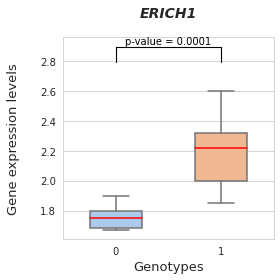

In [195]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_del_new[[0, 1]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Gene expression levels', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('ERICH1', pad=20, fontsize=14, fontweight='bold', style='italic')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_del_new[1].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0001", ha='center', va='bottom', color=col)

plt.show()

In [158]:
gene_expression_list = gene_INS_boundary_sample_rename_new.iloc[0, 2:28].values.tolist()
INS_boundary_genotype_all = INS_boundary_genotype[INS_boundary_genotype.loc[:,'INFO_ID'] == gene_INS_boundary_sample_rename_new.loc[0,'INFO_ID']].iloc[:,8:34]
genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
df_ins = pd.DataFrame({'genotypes' : genotypes_list,
                   'gene_expression' : gene_expression_list})
df_ins_new = df_ins.assign(expression=df_ins.groupby('genotypes').cumcount()).pivot('expression','genotypes','gene_expression')

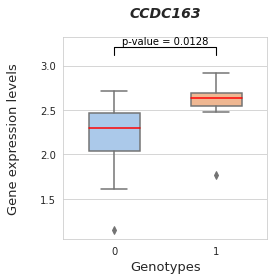

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_ins_new[[0, 1]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Gene expression levels', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('CCDC163', pad=20, fontsize=14, fontweight='bold', style='italic')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_ins_new[1].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0128", ha='center', va='bottom', color=col)

plt.show()

## SVs that significantly disrupt the TAD boundaries are also sQTLs

In [160]:
sqtl = pd.read_csv('qtl_results_all_v2_fdr0.05.txt', sep = '\t')

In [161]:
sqtl.shape

(1103872, 22)

In [162]:
pangenie_svs_sample_DEL_sqtl = sqtl[(sqtl['snp_id'].isin(all_DEL_boundary_3_sig['INFO_ID']))]

In [163]:
pangenie_svs_sample_DEL_sqtl.shape

(15, 22)

In [164]:
# number of unique deletions
len(pangenie_svs_sample_DEL_sqtl['snp_id'].drop_duplicates())

6

In [165]:
# number of unique splice junctions
len(pangenie_svs_sample_DEL_sqtl['feature_id'].drop_duplicates())

15

In [166]:
pangenie_svs_sample_INS_sqtl = sqtl[(sqtl['snp_id'].isin(all_INS_boundary_3_sig['INFO_ID']))]

In [167]:
pangenie_svs_sample_INS_sqtl.shape

(19, 22)

In [168]:
# number of unique insertions
len(pangenie_svs_sample_INS_sqtl['snp_id'].drop_duplicates())

5

In [169]:
# number of unique splice junctions
len(pangenie_svs_sample_INS_sqtl['feature_id'].drop_duplicates())

19

In [170]:
sqtl_DEL_boundary_feature = list(pangenie_svs_sample_DEL_sqtl['feature_id'])
sqtl_INS_boundary_feature = list(pangenie_svs_sample_INS_sqtl['feature_id'])

In [171]:
splicing_ratio = pd.read_csv('LCL_perind.counts.qqnorm.CovariatesRemoved.cs.txt', sep='\t', header = 0, index_col=0)

In [172]:
splicing_ratio.shape

(143713, 444)

In [173]:
splicing_DEL_boundary = splicing_ratio.filter(items = sqtl_DEL_boundary_feature, axis=0)
splicing_INS_boundary = splicing_ratio.filter(items = sqtl_INS_boundary_feature, axis=0)

In [174]:
sample = ['NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732']
splicing_DEL_boundary_sample = splicing_DEL_boundary.filter(regex='|'.join(sample), axis=1)
splicing_INS_boundary_sample = splicing_INS_boundary.filter(regex='|'.join(sample), axis=1)
## only keep the first 7 characters of the columns name
splicing_DEL_boundary_sample_rename = splicing_DEL_boundary_sample.rename(columns = lambda x : str(x)[:7])
splicing_INS_boundary_sample_rename = splicing_INS_boundary_sample.rename(columns = lambda x : str(x)[:7])
splicing_DEL_boundary_sample_rename_new = splicing_DEL_boundary_sample_rename.reset_index().rename(columns={'index': 'feature_id'})
splicing_INS_boundary_sample_rename_new = splicing_INS_boundary_sample_rename.reset_index().rename(columns={'index': 'feature_id'})

In [177]:
INFO_ID = list(pangenie_svs_sample_DEL_sqtl.iloc[:, 1])
len(INFO_ID)

15

In [179]:
splicing_DEL_boundary_sample_rename_new['INFO_ID'] = INFO_ID 
splicing_DEL_boundary_sample_rename_new = splicing_DEL_boundary_sample_rename_new[[
'feature_id','INFO_ID', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [180]:
INFO_ID = list(pangenie_svs_sample_INS_sqtl.iloc[:, 1])
len(INFO_ID)

19

In [181]:
splicing_INS_boundary_sample_rename_new['INFO_ID'] = INFO_ID 
splicing_INS_boundary_sample_rename_new = splicing_INS_boundary_sample_rename_new[[
'feature_id','INFO_ID', 'NA18534','NA18939','NA19036','NA19240','NA19650','NA19983','NA20509','NA20847','HG00096','HG00171','HG00514','HG00733','HG00864','HG01114','HG01505','HG01573','HG01596','HG02011','HG02018','HG02492','HG02587','HG03009','HG03065','HG03371','HG03683','HG03732'
    ]]

In [184]:
### test for genotypes 0 and 1
pvalue= []
for i in range(0, len(splicing_DEL_boundary_sample_rename_new)):
    DEL_boundary_genotype_all = DEL_boundary_genotype[DEL_boundary_genotype.loc[:,'INFO_ID'] == splicing_DEL_boundary_sample_rename_new.loc[i,'INFO_ID']].iloc[:,8:35]
    genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
    splicing_ratio_list = splicing_DEL_boundary_sample_rename_new.iloc[i, 2:28].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'splicing_ratio' : splicing_ratio_list})
    
    df_new = df.assign(splicing=df.groupby('genotypes').cumcount()).pivot('splicing','genotypes','splicing_ratio')
    
    try:
        U, p = mannwhitneyu(x=df_new[0].dropna().tolist(), y=df_new[1].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except KeyError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
splicing_DEL_boundary_sample_rename_new['pvalue_0_1'] = pvalue

In [185]:
splicing_DEL_boundary_sample_rename_new[splicing_DEL_boundary_sample_rename_new['pvalue_0_1'] < 0.05]

,feature_id,INFO_ID,NA18534,NA18939,NA19036,NA19240,NA19650,NA19983,NA20509,NA20847,...,HG02011,HG02018,HG02492,HG02587,HG03009,HG03065,HG03371,HG03683,HG03732,pvalue_0_1
1,6:87391835:87392725:clu_24429_+,chr6-87408456-DEL-133,-0.936184,0.012348,1.076310,2.158304,-0.932265,0.412867,-0.841126,-0.767154,...,-0.708359,0.036234,-1.040756,-1.141381,0.385166,-0.996222,-1.159694,0.681233,-0.554325,0.014847
4,8:70669538:70674818:clu_22301_+,chr8-70671321-DEL-1088,-0.005980,-0.950419,-0.399550,-0.929802,2.013419,-1.227758,2.069432,-1.077835,...,-0.780188,-1.215290,-0.646946,1.773509,-1.187269,0.009941,1.334757,0.612355,-0.937157,0.000244
5,8:664676:668598:clu_8652_-,chr8-644401-DEL-5014,1.245457,-0.414052,1.217779,-0.759694,1.209294,1.131286,-0.186955,0.427311,...,0.134623,0.345217,1.370163,1.423127,0.506337,1.393303,0.331152,0.336981,0.661554,0.012405
6,8:70652752:70653695:clu_22301_+,chr8-70671321-DEL-1088,0.704935,1.305387,0.883035,0.859624,-1.808690,0.580523,-2.483752,0.948607,...,-0.185246,0.328117,0.560184,-1.196977,0.807123,-0.060676,-0.594006,0.057426,0.818711,0.000140
7,8:640834:668598:clu_8652_-,chr8-644401-DEL-5014,-1.331250,1.221957,-1.475604,0.898362,-1.557109,-1.498409,0.061330,0.288855,...,0.414936,0.447919,-1.577237,-1.630796,-0.181406,-1.552799,-0.199111,-0.010256,-0.255825,0.040924
10,20:35632923:35664760:clu_21372_-,chr20-35960724-DEL-60,1.746169,0.529841,0.298889,-0.216541,-0.391229,0.191113,0.014453,-0.368097,...,1.366691,-0.306092,-0.028003,-0.167166,-0.169622,-0.432385,-0.916697,-0.475933,-0.963485,0.020419
11,20:35655344:35658930:clu_21372_-,chr20-35960724-DEL-60,-2.666742,-0.113100,-0.047915,0.324691,0.682168,0.111165,0.232633,0.199351,...,-0.019236,0.522568,0.629328,0.722698,0.518111,0.397488,0.963883,0.527364,1.150455,0.031556
12,20:35632923:35658930:clu_21372_-,chr20-35960724-DEL-60,0.152098,0.418184,0.353582,0.031710,-0.009831,1.008811,0.817291,-0.411666,...,1.039998,0.128767,0.239788,-0.015342,0.578768,-0.050955,-2.056413,-0.244741,-1.089664,0.007701
13,20:35626381:35626735:clu_21369_-,chr20-35960724-DEL-60,-0.432567,0.036543,-0.758824,0.380615,0.448366,-0.411455,0.123351,0.158921,...,0.118498,-0.012096,0.846607,0.066323,0.321752,0.041438,0.769644,0.496257,0.992429,0.007701
14,20:35626381:35626567:clu_21369_-,chr20-35960724-DEL-60,0.548644,0.026216,0.522271,-0.070876,-0.411626,0.380335,-0.271860,-0.091484,...,0.172651,0.484570,-0.176643,0.101298,-0.041055,-0.358616,-0.959188,0.294405,-1.346577,0.012772


In [186]:
### test for genotypes 0 and 1
pvalue= []
for i in range(0, len(splicing_INS_boundary_sample_rename_new)):
    INS_boundary_genotype_all = INS_boundary_genotype[INS_boundary_genotype.loc[:,'INFO_ID'] == splicing_INS_boundary_sample_rename_new.loc[i,'INFO_ID']].iloc[:,8:35]
    genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
    splicing_ratio_list = splicing_INS_boundary_sample_rename_new.iloc[i, 2:28].values.tolist()

    df = pd.DataFrame({'genotypes' : genotypes_list,
                   'splicing_ratio' : splicing_ratio_list})
    
    df_new = df.assign(splicing=df.groupby('genotypes').cumcount()).pivot('splicing','genotypes','splicing_ratio')
    
    try:
        U, p = mannwhitneyu(x=df_new[0].dropna().tolist(), y=df_new[1].dropna().tolist(), method="exact", alternative = 'two-sided')
        #print (p)
        
    except KeyError:
        p = 'NA'
        #print (p)
    
    pvalue.append(p)
    
splicing_INS_boundary_sample_rename_new['pvalue_0_1'] = pvalue

In [187]:
splicing_INS_boundary_sample_rename_new[splicing_INS_boundary_sample_rename_new['pvalue_0_1'] < 0.05]

,feature_id,INFO_ID,NA18534,NA18939,NA19036,NA19240,NA19650,NA19983,NA20509,NA20847,...,HG02011,HG02018,HG02492,HG02587,HG03009,HG03065,HG03371,HG03683,HG03732,pvalue_0_1
2,1:45495166:45496556:clu_28892_-,chr1-45497763-INS-354,-0.097358,0.798389,0.295351,-0.274953,0.299073,0.053754,-0.131064,-0.416363,...,-0.276865,0.627438,-0.162830,-1.278557,-0.814071,0.670716,0.499751,-1.262515,0.616364,0.031556
4,1:45551155:45552436:clu_13870_+,chr1-45497763-INS-354,-1.746480,0.475494,-0.078211,-0.445241,-0.698239,-2.578916,0.338158,1.013390,...,0.299322,-0.391775,0.861487,0.718653,-0.177377,-0.359558,-0.607451,0.442949,-0.515916,0.000822
10,12:11121180:11171422:clu_25806_-,chr12-11098150-INS-32251,0.657314,1.166145,-0.626568,-0.257784,0.235310,0.604133,-1.745503,-0.246276,...,0.128154,0.020220,-0.308632,0.563973,1.268727,-0.284257,-0.566251,0.857297,1.300180,0.000130
13,12:10895329:10973655:clu_25805_-,chr12-11098150-INS-32251,-1.100388,0.981214,-1.552212,-1.182824,-1.558485,0.654225,-1.506281,0.645814,...,-1.222811,1.019522,-1.421757,-1.519987,0.796199,1.639152,-0.034894,-1.230914,0.878924,0.003681
16,19:37507047:37508265:clu_27679_+,chr19-37789443-INS-1092,-0.422717,0.996525,1.166925,1.740052,-1.491070,1.274219,-1.437013,-1.299856,...,1.308221,0.340187,-1.421464,-1.307926,-1.419196,-0.705460,2.317070,-1.440027,2.429939,0.012233
18,19:37506966:37508265:clu_27679_+,chr19-37789443-INS-1092,-0.979127,-0.070640,-0.223306,0.464992,-0.226925,-1.221188,0.261882,0.507532,...,-0.273729,-0.429555,0.628614,0.699270,0.069109,-1.075881,-1.017312,2.135377,-0.967641,0.035602


#### Visualization of chr8-644401-DEL-5014 and chr1-45497763-INS-354

In [188]:
gene_splicing_list = splicing_DEL_boundary_sample_rename_new.iloc[5, 2:28].values.tolist()
DEL_boundary_genotype_all = DEL_boundary_genotype[DEL_boundary_genotype.loc[:,'INFO_ID'] == splicing_DEL_boundary_sample_rename_new.loc[5,'INFO_ID']].iloc[:,8:35]
genotypes_list = DEL_boundary_genotype_all.iloc[0].values.tolist()
df_Del = pd.DataFrame({'genotypes' : genotypes_list,
                   'gene_splicing' : gene_splicing_list})
df_Del_new = df_Del.assign(splicing=df_Del.groupby('genotypes').cumcount()).pivot('splicing','genotypes','gene_splicing')

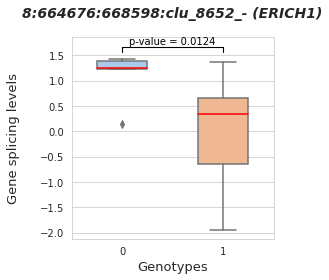

In [190]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_Del_new[[0, 1]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Gene splicing levels', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('8:664676:668598:clu_8652_- (ERICH1)', pad=20, fontsize=14, fontweight='bold', style='italic')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_Del_new[1].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0124", ha='center', va='bottom', color=col)

plt.show()

In [201]:
gene_splicing_list = splicing_INS_boundary_sample_rename_new.iloc[2, 2:28].values.tolist()
INS_boundary_genotype_all = INS_boundary_genotype[INS_boundary_genotype.loc[:,'INFO_ID'] == splicing_INS_boundary_sample_rename_new.loc[2,'INFO_ID']].iloc[:,8:35]
genotypes_list = INS_boundary_genotype_all.iloc[0].values.tolist()
df_Ins = pd.DataFrame({'genotypes' : genotypes_list,
                   'gene_splicing' : gene_splicing_list})
df_Ins_new = df_Ins.assign(splicing=df_Ins.groupby('genotypes').cumcount()).pivot('splicing','genotypes','gene_splicing')

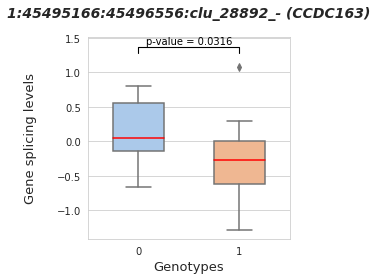

In [202]:
# Set Seaborn's default style and color palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create the boxplot using Seaborn
plt.figure(figsize=(4, 4))  # Adjust the figure size
ax = sns.boxplot(data=df_Ins_new[[0, 1]], palette="pastel", medianprops=dict(color='red'), width=0.5)

# Set labels, titles, and other properties
ax.set_ylabel('Gene splicing levels', fontsize=13, labelpad=20)
ax.set_xlabel('Genotypes', fontsize=13)
ax.set_title('1:45495166:45496556:clu_28892_- (CCDC163)', pad=20, fontsize=14, fontweight='bold', style='italic')

# Display the plot
plt.tight_layout()

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = df_Ins_new[1].max() + 0.2, 0.1, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.1, c=col)
plt.text((x1+x2)*.5, y+h, "p-value = 0.0316", ha='center', va='bottom', color=col)

plt.show()